# Completing Historical Temperature records with LSTM in Python

https://medium.com/analytics-vidhya/completing-historical-temperature-records-with-lstm-in-python-f505b10289e7

https://github.com/gnaya73/medium

# Handling Outliers 

In [1]:
import pandas as pd
import numpy as np
import os
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

random.seed(7)

In [2]:
df = pd.read_csv("CoCoRaHs_Reg4.csv", parse_dates=["DATE"])
df.set_index('DATE',inplace=True)
print(df.describe())

            LATITUDE      LONGITUDE      ELEVATION           PRCP  \
count  691683.000000  691683.000000  691683.000000  249033.000000   
mean       40.614650    -123.149282     665.203173       0.179896   
std         0.957032       0.594506     538.058815       0.470019   
min        38.508471    -124.281608       0.000000       0.000000   
25%        39.927800    -123.603600     152.400000       0.000000   
50%        40.710884    -123.083300     579.100000       0.000000   
75%        41.307500    -122.696700    1088.100000       0.100000   
max        42.080000    -122.144700    1844.000000      12.410000   

                TMAX           TMIN  
count  461946.000000  461938.000000  
mean       67.022782      43.772602  
std        22.415863      14.107114  
min      -100.000000    -100.000000  
25%        52.000000      35.000000  
50%        66.000000      43.000000  
75%        82.000000      52.000000  
max      4177.000000    4177.000000  


# Drop either T > 120 F or T<0 F 

In [3]:
df.loc[df.TMIN > 90, 'TMIN'] = np.nan
df.loc[df.TMIN < 0, 'TMIN'] = np.nan

df.loc[df.TMAX > 120, 'TMAX'] = np.nan
df.loc[df.TMAX < 30, 'TMAX'] = np.nan

# Pivot Table

In [4]:
df.pivot_table(df,'STATION',aggfunc=np.max)

,ELEVATION,LATITUDE,LONGITUDE,NAME,PRCP,TMAX,TMIN
STATION,,,,,,,
US1CACL0001,27.7,39.349023,-122.177112,MAXWELL 5.1 N,3.82,NaN,NaN
US1CADN0001,19.8,41.824032,-124.148236,CRESCENT CITY 5.5 NNE,6.68,NaN,NaN
US1CADN0005,29.9,41.799773,-124.142767,CRESCENT CITY 4.2 NE,6.15,NaN,NaN
US1CADN0006,36.6,41.915283,-124.135986,SMITH RIVER 1.1 SSE,7.07,NaN,NaN
US1CADN0007,14.9,41.865256,-124.151284,FORT DICK 0.2 SSW,6.36,NaN,NaN
...,...,...,...,...,...,...,...
USR0000CYOL,1378.8,40.337500,-123.065600,YOLLA BOLLA,NaN,106.0,73.0
USR0000CYUR,150.9,41.289700,-123.857500,YUROK,NaN,117.0,79.0
USR0000OSQU,1513.0,42.066700,-123.016700,SQUAW PEAK,NaN,120.0,89.0


In [5]:
# P1 = pd.pivot_table(df, values='TMIN',index=['DATE'], columns=['STATION'])
# P1 = pd.pivot_table(df, values='PRCP',index=['DATE'], columns=['STATION'])
import matplotlib.pyplot as plt
P1 = pd.pivot_table(df, values='TMAX',index=['DATE'],columns=['STATION'])
print(P1)
#P1.plot(style=['k--', 'bo-', 'r*'], figsize=(20, 10))
#plt.ylabel("TMAX (F)")

STATION     USR0000CABS  USR0000CALD  USR0000CAPT  USR0000CBAC  USR0000CBBR  \
DATE                                                                          
1985-01-23          NaN          NaN          NaN          NaN          NaN   
1985-01-24          NaN          NaN          NaN          NaN          NaN   
1985-01-25          NaN          NaN          NaN          NaN          NaN   
1985-01-26          NaN          NaN          NaN          NaN          NaN   
1985-01-28          NaN          NaN          NaN          NaN          NaN   
...                 ...          ...          ...          ...          ...   
2020-03-18         43.0         34.0         56.0         40.0         55.0   
2020-03-19         52.0         46.0         63.0         48.0         64.0   
2020-03-20         56.0         49.0         64.0         52.0         67.0   
2020-03-21         63.0         56.0         70.0         57.0         73.0   
2020-03-22         59.0         54.0         60.0   

#  Box Plot with sns

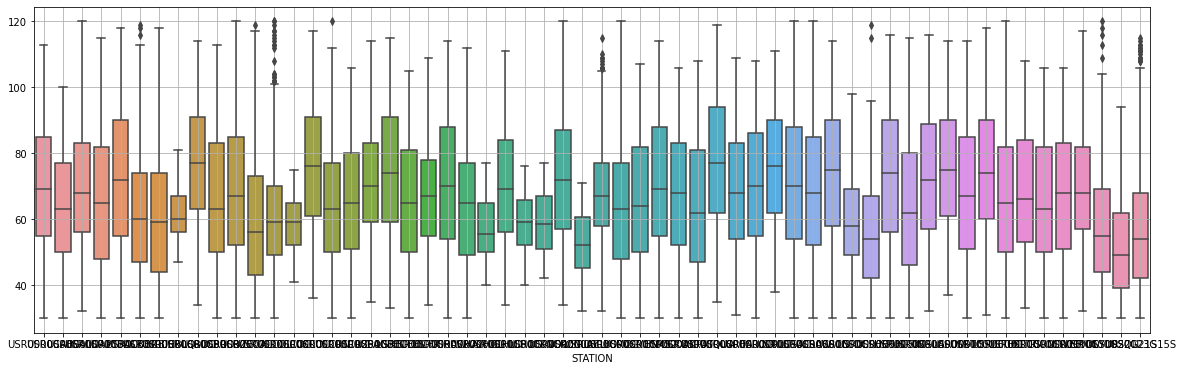

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches((20,6))
sns.boxplot(data=P1,ax=ax)
plt.grid()
plt.show()

Text(0, 0.5, 'TMAX (F)')

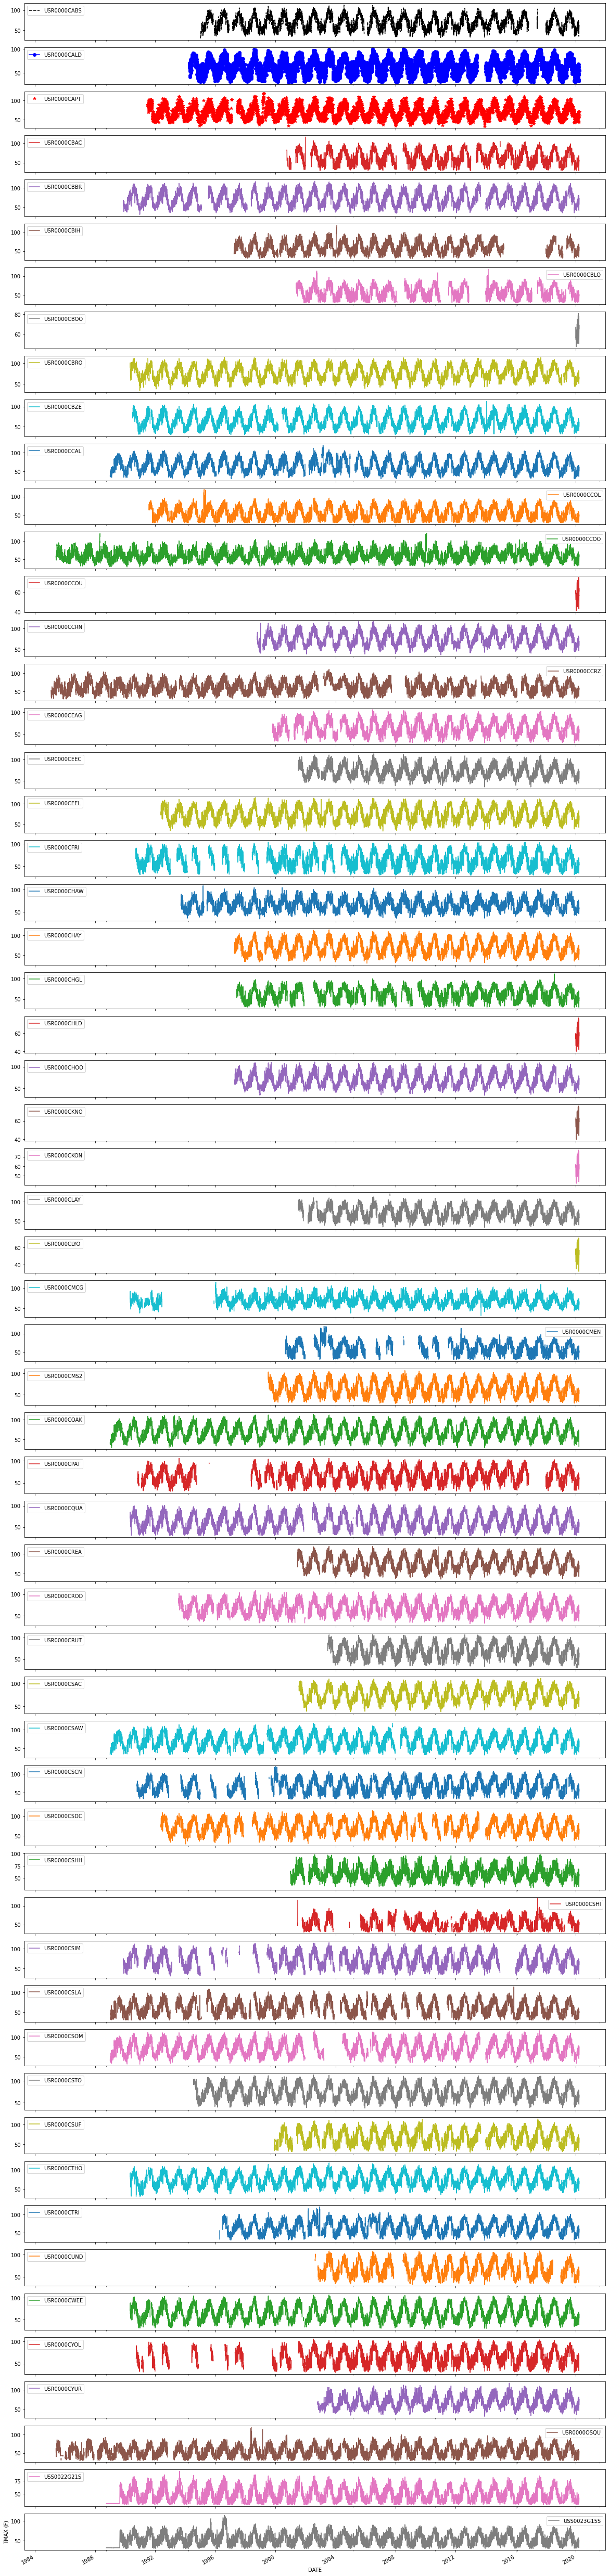

In [13]:
P1.plot(style=['k--', 'bo-', 'r*'], figsize=(20, 100),subplots=True)

plt.ylabel("TMAX (F)")

# Fill out Missing data by Using LSTM

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

Isnull = P2.isnull().sum()/len(P2)*100
Isnull = Isnull[Isnull>0]
Isnull.sort_values(inplace=True, ascending=False)
Isnull = Isnull.to_frame()
Isnull.columns = ['Nulls']
Isnull.index.names = ['Stations']
Isnull['Stations'] = Isnull.index
# plot Missing values
plt.figure(figsize=(13, 5))
sns.set(style='darkgrid',color_codes=True,)
sns.barplot(x='Stations', y='Nulls', data=Isnull)
plt.xticks(rotation = 90)
plt.show()

# Visualizing null data in heatmap

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(P2.isnull())
plt.show()

We can observe that the information (black background) is quite compact in the period 
January-1985 to December 2000
Dropping null records in the whole dataset we we have a final set of 1477 records,
between 01/23/1985 and 12/31/1990

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(P2.loc['1990-10-01':'2020-12-31'].isnull())
plt.show()

In [ ]:
 P2.dropna(inplace=True)
 P2.info()

In [ ]:
anual = P2.groupby(P2.index.year)
serie = anual.size()

plt.figure(figsize=(13, 5))
sns.set(style='whitegrid')
sns.barplot(x=serie.index, y=serie)
plt.xticks(rotation = 90)
plt.show()

# Let's start working with regression algorithms, we are going to make a copy of the
# "merge" dataset to leave the original intact

In [ ]:
# print aca freno

In [ ]:
data = P2.copy()
data.head(20)

In [ ]:
# We add sine and cosine depending on the day of the year, in case we need that information later
# We create a column for the day of the year, which will go from 0 to 360

data['Day'] = 0
length_months = [31,28,31,30,31,30,31,31,30,31,30,31]

for idx,row in data.iterrows():
    day = idx.day
    if idx.month > 1:
        for m in range(idx.month-1):
            day = day + length_months[m]
    if day >= 360:
        day = 0    
    data.loc[data.index == idx ,'Day'] = float(day)

  
data['Sin'] = np.abs(np.sin(data['Day'] * np.pi/180)) 
data['Cos'] = np.abs(np.cos(data['Day'] * np.pi/180))
data.head(10)

# Using the LSTM network to predict missing data records

First, let’s scale the data using MinMaxScaler. I like using a dataset copy in my 
Jupiter Notebook at the end of feature work, then I can make differents approaches to the goal without affecting the final dataset.
In this case, variables have similar values, then scaling could not be neccesary,
but I like to work with low and similar values always it is posible.

In [ ]:
#print (math.sin(math.radians(45)))
#print (math.sin(45 * (np.pi/180) ))

In [ ]:
# Let's go for an approximation
cols = ['USR0000CCOO','USR0000CLAY','USR0000CCRZ','USS0022G21S','USR0000CEEC','USS0023G15S'] 

X = data[cols]
X.reset_index(inplace=True, drop=True)

Y = data['USR0000CLAY']
Y.reset_index(inplace=True, drop=True)

#  When cutting the dataset we respect the sequentiality of the data
rate = 0.75  
tst_train = int(len(data)*rate)
tst_test = len(data) - tst_train

X_train, X_test = X.iloc[0:tst_train,:],X.iloc[tst_train:len(X),:]
y_train, y_test = Y.iloc[0:tst_train],Y.iloc[tst_train:len(Y)]

print ("Shape of X_train & y_train : ",X_train.shape,y_train.shape)
print ("Shape of X_test  & y_test  : ", X_test.shape , y_test.shape)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, accuracy_score, confusion_matrix

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                max_depth=4, max_features='sqrt',
                                min_samples_leaf=15, min_samples_split=10,
                                loss='huber', random_state=7)
gbr_model_full_data = gbr.fit(X_train, y_train)
print('Gradiente RMSLE score on train data:')
print(rmsle(y_train, gbr_model_full_data.predict(X_train)))
print("Accuracy --> ", gbr_model_full_data.score(X_train, y_train)*100)

print('Gradiente RMSLE score on test data:')
print(rmsle(y_test, gbr_model_full_data.predict(X_test)))
print("Accuracy --> ", gbr_model_full_data.score(X_test, y_test)*100)

# Let's go for an LSTM network

In [ ]:
from sklearn.preprocessing import MinMaxScaler
dataset = P2.copy()
scaler = MinMaxScaler()
reshape  = ['USR0000CCOO','USR0000CLAY','USR0000CCRZ','USS0022G21S','USR0000CEEC','USS0023G15S']
dataset[reshape] = scaler.fit_transform(dataset[reshape])
dataset.head()

In [ ]:
#def create_dataset(dataset, look_back=1, ofs=0):
#    dataX, dataY = [], []
#    for i in range(ofs,len(dataset)-look_back-1+ofs):
#        a = np.array(dataset.loc[i:(i+look_back), :])                
#        dataX.append(a)
#        dataY.append(np.array(dataset.loc[i + look_back , :]))
#    return np.array(dataX), np.array(dataY)

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = np.array(dataset.loc[i:(i+look_back), :])        
        dataX.append(a)
        dataY.append(np.array(dataset.loc[i + look_back, :]))
    return np.array(dataX), np.array(dataY)

def create_dataset2(dataset, look_back=1, ofs=0):
    dataX, dataY = [], []
    for i in range(ofs,len(dataset)-look_back-1+ofs):
        a = np.array(dataset.loc[i:(i+look_back), :])                  
        dataX.append(a)
        dataY.append(np.array(dataset.loc[i + look_back , :]))
    return np.array(dataX), np.array(dataY)

In [ ]:
rate = 0.75  
tst_train_len = int(len(dataset)*rate)
tst_test_len = len(dataset) - tst_train
dataset.reset_index(inplace=True, drop=True)
train, test = dataset.loc[0:tst_train_len,:],dataset.loc[tst_train_len:len(dataset),:]

print (train.shape)
print (test.shape)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import ModelCheckpoint

look_back = 4

trainX, trainY = create_dataset(train,look_back)
# For the test the index moves and you have to do other things
testX, testY = create_dataset2(test,look_back,4087)

print (testX.shape)
print (testY.shape)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import ModelCheckpoint

dataset = P2.copy()

cnt_perc = 6
cnt_epoch = 50
bz = 1


model = Sequential()
model.add(LSTM(cnt_perc, input_shape=(look_back+1,6)))
model.add(Dense(6))
model.summary()
model.compile(loss='mean_squared_error', optimizer='adam')


model.fit(trainX, trainY, epochs=cnt_epoch, batch_size=bz, verbose=2) #,  callbacks=[checkpointer])


In [ ]:
dataset = P2.copy()
scaler = MinMaxScaler()
reshape  = ['USR0000CCOO','USR0000CLAY','USR0000CCRZ','USS0022G21S','USR0000CEEC','USS0023G15S']
dataset[reshape] = scaler.fit_transform(dataset[reshape])
original = scaler.inverse_transform(dataset)
print (original[0:10,:])
P2.head(10)

In [ ]:
# I create the prediction for the input datasets, the predictions have the output format equal to trainY / testY
trainPredict = np.round(scaler.inverse_transform(model.predict(trainX)))
testPredict = scaler.inverse_transform(model.predict(testX))

#print (original[1112:1112+365,4])    
#print (np.round(testPredict[0:365,4]))

In [ ]:
print (len(original))
print (len(trainX))
print (len(trainX)+(look_back*2)+1)

In [ ]:
from sklearn.metrics import mean_squared_error
import math

trainScore = math.sqrt(mean_squared_error(original[look_back:(len(trainX)+look_back),4], trainPredict[:,4]))
print('Train: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(original[len(trainX)+(look_back*2)+1:,4], testPredict[:,4]))
print('Test: %.2f RMSE' % (testScore))

In [ ]:
# I prepare the predictions on the training data to graph
# trainPredictPlot = np.empty_like(original[1:1107,4])
# trainPredictPlot[:, :] = np.nan
# trainPredictPlot[1:len(trainPredict)+1, :] = trainPredict[:,4]

# I prepare the predictions on the test data to graph
# testPredictPlot = np.empty_like(dataset)
# testPredictPlot[:, :] = np.nan
# testPredictPlot[len(trainPredict)+(2)+1:len(dataset)-1, :] = testPredict

# Grafico
plt.figure(figsize=(13, 5))
plt.plot(original[4:1107,4])
plt.plot(trainPredict[:,4])
plt.plot(testPredict[:,4])
plt.show()

In [ ]:
# Graphic
plt.figure(figsize=(13, 5))
plt.plot(original[1112:,4])
plt.plot(testPredict[:,4])
plt.show()

In [ ]:
df = pd.train
df.to_csv("Imputed_Tmax.csv")